This notebook is adapted from [here](https://docs.pymc.io/notebooks/lda-advi-aevb.html)

In [1]:
%matplotlib inline
import sys, os
# unfortunately I was not able to run it on GPU due to overflow problems
%env THEANO_FLAGS=device=cpu,floatX=float64
import theano

from collections import OrderedDict
from copy import deepcopy
import numpy as np
from time import time
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.datasets import fetch_20newsgroups
import matplotlib.pyplot as plt
import seaborn as sns
from theano import shared
import theano.tensor as tt
from theano.sandbox.rng_mrg import MRG_RandomStreams

import pymc3 as pm
from pymc3 import math as pmmath
from pymc3 import Dirichlet
from pymc3.distributions.transforms import t_stick_breaking
plt.style.use('seaborn-darkgrid')

env: THEANO_FLAGS=device=cpu,floatX=float64


WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named 'mkl'


## Dataset

In [2]:
# The number of words in the vocabulary
n_words = 1000

print("Loading dataset...")
t0 = time()
dataset = fetch_20newsgroups(shuffle=True, random_state=1,
                             remove=('headers', 'footers', 'quotes'))
data_samples = dataset.data
print("done in %0.3fs." % (time() - t0))

# Use tf (raw term count) features for LDA.
print("Extracting tf features for LDA...")
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2, max_features=n_words,
                                stop_words='english')

t0 = time()
tf = tf_vectorizer.fit_transform(data_samples)
feature_names = tf_vectorizer.get_feature_names()
print("done in %0.3fs." % (time() - t0))

Loading dataset...
done in 1.456s.
Extracting tf features for LDA...
done in 1.699s.


## Train and test

In [3]:
n_samples_tr = 10000
n_samples_te = tf.shape[0] - n_samples_tr
docs_tr = tf[:n_samples_tr, :]
docs_te = tf[n_samples_tr:, :]
print('Number of docs for training = {}'.format(docs_tr.shape[0]))
print('Number of docs for test = {}'.format(docs_te.shape[0]))

n_tokens = np.sum(docs_tr[docs_tr.nonzero()])
print('Number of tokens in training set = {}'.format(n_tokens))
print('Sparsity = {}'.format(
    len(docs_tr.nonzero()[0]) / float(docs_tr.shape[0] * docs_tr.shape[1])))

Number of docs for training = 10000
Number of docs for test = 1314
Number of tokens in training set = 480263
Sparsity = 0.0253936


## Likelihood of documents for LDA

In [4]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(url= "image/lda.png")

In [5]:
"""
def logp_lda_doc(beta, theta):
    "Returns the log-likelihood function for given documents.

    K : number of topics in the model
    V : number of words (size of vocabulary)
    D : number of documents (in a mini-batch)

    Parameters
    ----------
    docs: tensor (D x V)
    beta : tensor (K x V)
        Word distributions.
    theta : tensor (D x K)
        Topic distributions for documents.
    "
    # the matrix product of theta and beta can give the likelihood of words,
    # to prevent underflow, use logsumexp
    # and multiply words frequencies
    # sum all likelihood in all docs
    print(tt.ones_like(pmmath.dot(theta,beta)))
    def ll_docs_f(docs):
        print(np.shape(docs))
        docs_lli = tt.sum(pmmath.dot(docs, pmmath.logsumexp(tt.log(pmmath.dot(theta,beta)))))
        # return likelihood per word
        return docs_lli/tt.sum(docs.nonzeros())
    return ll_docs_f
"""

def logp_lda_doc(beta, theta):
    """Returns the log-likelihood function for given documents.

    K : number of topics in the model
    V : number of words (size of vocabulary)
    D : number of documents (in a mini-batch)

    Parameters
    ----------
    beta : tensor (K x V)
        Word distributions.
    theta : tensor (D x K)
        Topic distributions for documents.
    """
    def ll_docs_f(docs):
        # the original matrix is large and sparse, here we only multiply the nonzero terms
        dixs, vixs = docs.nonzero()
        vfreqs = docs[dixs, vixs]
        print(np.shape(theta[dixs].tag.test_value))
        print(np.shape(beta.T[vixs].tag.test_value))
        print(np.shape(vfreqs.tag.test_value))
        ll_docs = vfreqs * pmmath.logsumexp(tt.log(theta[dixs]) + tt.log(beta.T[vixs]), axis=1).ravel()
        a = pmmath.logsumexp(tt.log(theta[dixs]) + tt.log(beta.T[vixs]), axis=1).ravel()
        print(np.shape(a.tag.test_value))
        # Per-word log-likelihood times num of tokens in the whole dataset
        # note here the vfreqs are only n_tokens in this batch, not n_tokens of the whole dataset
        return tt.sum(ll_docs) / (tt.sum(vfreqs)+1e-9) * n_tokens
  
    return ll_docs_f   


## Parameter estimation

In [6]:
n_topics = 10
# we have sparse dataset. It's better to have dense batch so that all words accure there
minibatch_size = 128
theano.config.gcc.cxxflags = "-Wno-c++11-narrowing"
# defining minibatch
doc_t_minibatch = pm.Minibatch(docs_tr.toarray(), minibatch_size)
doc_t = shared(docs_tr.toarray()[:minibatch_size])
with pm.Model() as model:
    theta = Dirichlet('theta', a=pm.floatX((1.0 / n_topics) * np.ones((minibatch_size, n_topics))),
                      shape=(minibatch_size, n_topics), transform=t_stick_breaking(1e-9),
                      total_size=n_samples_tr)
    # I think here should be 1/n_words instead of n_topics
    beta = Dirichlet('beta', a=pm.floatX((1.0 / n_topics) * np.ones((n_topics, n_words))),
                     shape=(n_topics, n_words), transform=t_stick_breaking(1e-9))
    # Note, that we defined likelihood with scaling, so here we need no additional `total_size` kwarg
    doc = pm.DensityDist('doc', logp_lda_doc(beta, theta), observed=doc_t)

/Users/yuexichen/anaconda3/envs/pgm-playground/lib/python3.7/site-packages/pymc3/data.py:246: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  self.shared = theano.shared(data[in_memory_slc])
/Users/yuexichen/anaconda3/envs/pgm-playground/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/Users/yuexichen/anaconda3/envs/pgm-playground/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multid

(3469, 10)
(3469, 10)
(3469,)
(3469,)
(3469, 10)
(3469, 10)
(3469,)
(3469,)
(3469, 10)
(3469, 10)
(3469,)
(3469,)


## LDA encoder

In [7]:
class LDAEncoder:
    """Encode (term-frequency) document vectors to variational means and (log-transformed) stds.
    """
    def __init__(self, n_words, n_hidden, n_topics, p_corruption=0, random_seed=1):
        rng = np.random.RandomState(random_seed)
        self.n_words = n_words
        self.n_hidden = n_hidden
        self.n_topics = n_topics
        self.w0 = shared(0.01 * rng.randn(n_words, n_hidden).ravel(), name='w0')
        self.b0 = shared(0.01 * rng.randn(n_hidden), name='b0')
        self.w1 = shared(0.01 * rng.randn(n_hidden, 2 * (n_topics - 1)).ravel(), name='w1')
        self.b1 = shared(0.01 * rng.randn(2 * (n_topics - 1)), name='b1')
        self.rng = MRG_RandomStreams(seed=random_seed)
        self.p_corruption = p_corruption

    def encode(self, xs):
        if 0 < self.p_corruption:
            dixs, vixs = xs.nonzero()
            mask = tt.set_subtensor(
                tt.zeros_like(xs)[dixs, vixs],
                self.rng.binomial(size=dixs.shape, n=1, p=1-self.p_corruption)
            )
            xs_ = xs * mask
        else:
            xs_ = xs

        w0 = self.w0.reshape((self.n_words, self.n_hidden))
        w1 = self.w1.reshape((self.n_hidden, 2 * (self.n_topics - 1)))
        hs = tt.tanh(xs_.dot(w0) + self.b0)
        zs = hs.dot(w1) + self.b1
        zs_mean = zs[:, :(self.n_topics - 1)]
        zs_rho = zs[:, (self.n_topics - 1):]
        return {'mu': zs_mean, 'rho':zs_rho}

    def get_params(self):
        return [self.w0, self.b0, self.w1, self.b1]

In [8]:
encoder = LDAEncoder(n_words=n_words, n_hidden=100, n_topics=n_topics, p_corruption=0.0)
local_RVs = OrderedDict([(theta, encoder.encode(doc_t))])
encoder_params = encoder.get_params()

## Fit the model

In [9]:
η = .1
s = shared(η)
def reduce_rate(a, h, i):
    s.set_value(η/((i/minibatch_size)+1)**.7)

with model:
    approx = pm.MeanField(local_rv=local_RVs)
    approx.scale_cost_to_minibatch = False
    inference = pm.KLqp(approx)
    inference.fit(10000, callbacks=[reduce_rate], obj_optimizer=pm.sgd(learning_rate=s),
              more_obj_params=encoder_params, total_grad_norm_constraint=200,
              more_replacements={doc_t: doc_t_minibatch})

  0%|          | 0/10000 [00:00<?, ?it/s]/Users/yuexichen/anaconda3/envs/pgm-playground/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
Average Loss = 2.9757e+06: 100%|██████████| 10000/10000 [02:30<00:00, 66.59it/s]
Finished [100%]: Average Loss = 2.9788e+06


## Print loss

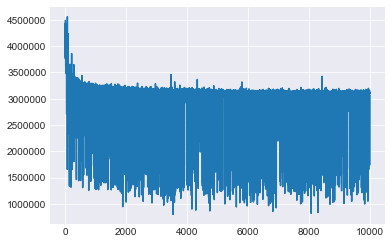

In [10]:
plt.plot(approx.hist[10:]);

## Print top words

In [11]:
def print_top_words(beta, feature_names, n_top_words=10):
    for i in range(len(beta)):
        print(("Topic #%d: " % i) + " ".join([feature_names[j]
            for j in beta[i].argsort()[:-n_top_words - 1:-1]]))


doc_t.set_value(docs_tr.toarray())
samples = pm.sample_approx(approx, draws=100)
beta_pymc3 = samples['beta'].mean(axis=0)

print_top_words(beta_pymc3, feature_names)

Topic #0: people think don god just know said say like time
Topic #1: ax max g9v b8f 75u a86 bhj pl 1t 145
Topic #2: use windows file edu drive program scsi using does like
Topic #3: key chip use encryption government clipper keys public people security
Topic #4: team year game good season think games like don just
Topic #5: space new nasa information research 000 gun 1993 university year
Topic #6: 00 10 25 11 17 15 20 16 14 24
Topic #7: car like just good new don used power price db
Topic #8: know like just don does thanks good edu mail ve
Topic #9: know like just don does thanks good edu ve think


## Perplexity

Instead of the predictive distribution, here we use the perplexity to evaluate the model.

In [12]:
Image(url= "image/perplexity.png", width=400)

In [13]:
def calc_perplexity(docs_te, theta, beta):
    """
    Parameters
    ----------
    docs_te: ndarray, shape = (N, V)
    ws: ndarray (N,)
        Number of words in N documents.
    thetas: ndarray, shape=(N, K)
        Topic distributions for N documents.
    beta: ndarray, shape=(K, V)
        Word distributions for K topics.
    Return
    ------
    Log probability of held-out words.
    """
    dixs_te, vixs_te = docs_te.nonzero()
    vfreqs_te = docs_te[dixs_te, vixs_te]
    # ravel is just reshape it to a 1-D array
    print(np.shape(vfreqs_te))
    print(np.shape(theta[dixs_te]))
    print(np.shape(beta.T[vixs_te]))
    ll_docs = vfreqs_te * pmmath.logsumexp(tt.log(theta[dixs_te]) + tt.log(beta.T[vixs_te]), axis=1).ravel()
    perplexity = tt.exp(-tt.sum(ll_docs)/tt.sum(vfreqs_te)) 
    return perplexity
    

In [14]:
samples = pm.sample_approx(approx, draws=100)
# updated beta 
beta_pymc3 = samples['beta'].mean(axis=0)

# Calculate theta for test docs
# more_replacements: doc_t is the training data in mini batches, and inp is the input, 
# i.e. here it's the test data

inp = tt.matrix(dtype='int64')
sample_vi_theta = theano.function(
    [inp],
    approx.sample_node(approx.model.theta, 100,  more_replacements={doc_t: inp}).mean(0)
)

def transform_pymc3(docs):
    return sample_vi_theta(docs)

# don't forget to use toarray()
docs_te_tt = shared(docs_te.toarray())
theta_pymc3 = transform_pymc3(docs_te_tt)

print(theta_pymc3)

TypeError: Bad input argument to theano function with name "<ipython-input-14-6a3b0b2435dd>:12" at index 0 (0-based).  
Backtrace when that variable is created:

  File "/Users/yuexichen/anaconda3/envs/pgm-playground/lib/python3.7/site-packages/ipykernel/zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/Users/yuexichen/anaconda3/envs/pgm-playground/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2848, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/Users/yuexichen/anaconda3/envs/pgm-playground/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2874, in _run_cell
    return runner(coro)
  File "/Users/yuexichen/anaconda3/envs/pgm-playground/lib/python3.7/site-packages/IPython/core/async_helpers.py", line 68, in _pseudo_sync_runner
    coro.send(None)
  File "/Users/yuexichen/anaconda3/envs/pgm-playground/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3051, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "/Users/yuexichen/anaconda3/envs/pgm-playground/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3242, in run_ast_nodes
    if (await self.run_code(code, result,  async_=asy)):
  File "/Users/yuexichen/anaconda3/envs/pgm-playground/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3319, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-14-6a3b0b2435dd>", line 9, in <module>
    inp = tt.matrix(dtype='int64')
Expected an array-like object, but found a Variable: maybe you are trying to call a function on a (possibly shared) variable instead of a numeric array?

In [15]:
perplexity = calc_perplexity(docs_te_tt, theta_pymc3, beta_pymc3)
print(perplexity.tag.test_value)

NameError: name 'theta_pymc3' is not defined

def calc_pp(ws, thetas, beta, wix):
    """
    Parameters
    ----------
    ws: ndarray (N,)
        Number of times the held-out word appeared in N documents.
    thetas: ndarray, shape=(N, K)
        Topic distributions for N documents.
    beta: ndarray, shape=(K, V)
        Word distributions for K topics.
    wix: int
        Index of the held-out word

    Return
    ------
    Log probability of held-out words.
    """
    return ws * np.log(thetas.dot(beta[:, wix]))

def eval_lda(transform, beta, docs_te, wixs):
    """Evaluate LDA model by log predictive probability.

    Parameters
    ----------
    transform: Python function
        Transform document vectors to posterior mean of topic proportions.
    wixs: iterable of int
        Word indices to be held-out.
    """
    lpss = []
    docs_ = deepcopy(docs_te)
    thetass = []
    wss = []
    total_words = 0
    for wix in wixs:
        ws = docs_te[:, wix].ravel()
        if 0 < ws.sum():
            # Hold-out
            docs_[:, wix] = 0

            # Topic distributions
            thetas = transform(docs_)

            # Predictive log probability
            lpss.append(calc_pp(ws, thetas, beta, wix))

            docs_[:, wix] = ws
            thetass.append(thetas)
            wss.append(ws)
            total_words += ws.sum()
        else:
            thetass.append(None)
            wss.append(None)

    # Log-probability
    lp = np.sum(np.hstack(lpss)) / total_words

    return {
        'lp': lp,
        'thetass': thetass,
        'beta': beta,
        'wss': wss
    }

inp = tt.matrix(dtype='int64')
sample_vi_theta = theano.function(
    [inp],
    approx.sample_node(approx.model.theta, 100,  more_replacements={doc_t: inp}).mean(0)
)
def transform_pymc3(docs):
    return sample_vi_theta(docs)

%time result_pymc3 = eval_lda(transform_pymc3, beta_pymc3, docs_te.toarray(), np.arange(100))
print('Predictive log prob (pm3) = {}'.format(result_pymc3['lp']))